In [1]:
import os
import h5py
import numpy as np
from typing import List, Dict, Callable
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

from ml4cvd.arguments import _get_tmap
from ml4cvd.TensorMap import TensorMap

/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '
Using TensorFlow backend.


In [10]:
def tmaps_by_sample_id(tensor_folder: str, sample_id: str, tmaps: List[TensorMap]):
    path = os.path.join(tensor_folder, sample_id + '.hd5')
    result_dict = defaultdict(lambda: None)
    if os.path.isfile(path):
            with h5py.File(path, 'r') as hd5:
                for tmap in tmaps:
                    try:
                        result_dict[tmap] = tmap.tensor_from_file(tmap, hd5)
                    except (IndexError, KeyError, ValueError, OSError, RuntimeError):
                        continue
    return result_dict


def tmaps_with_properties(tensor_folder: str, tmap_properties: Dict[TensorMap, Callable[[np.ndarray], bool]], search_size=100):
    all_ids = [file.strip('.hd5') for file in sorted(os.listdir(tensor_folder))[:search_size]]
    results = map(lambda sample_id: tmaps_by_sample_id(tensor_folder, sample_id, tmap_properties.keys()), all_ids)
    return {
        sample_id: result
        for sample_id, result in zip(all_ids, results)
        if all(
            result[tmap] is not None and tmap_properties[tmap](result[tmap])
            for tmap in tmap_properties.keys()
        )
    }


def tmaps_with_properties_from_keys(tensor_folder: str, tmap_properties: Dict[str, Callable[[np.ndarray], bool]], search_size=100):
    return tmaps_with_properties(
        tensor_folder,
        {_get_tmap(key): prop for key, prop in tmap_properties.items()},
        search_size,
    )


def plot_nifti_array_3d(a, slice_axis=-1):
    sides = int(np.ceil(np.sqrt(a.shape[slice_axis])))
    _, axes = plt.subplots(sides, sides, figsize=(16, 16))
    print(a.shape)
    vmin = np.min(a)
    vmax = np.max(a)
    for i in range(a.shape[slice_axis]):
        axes[i//sides, i%sides].imshow(np.flip(np.swapaxes(a[..., i], 0, 1)), cmap='gray', vmin=vmin, vmax=vmax)
        axes[i//sides, i%sides].set_yticklabels([])
        axes[i//sides, i%sides].set_xticklabels([])

In [3]:
tmaps = [_get_tmap('t1_30_slices'), _get_tmap('t1_dicom_30_slices'),_get_tmap('t2_flair_30_slices'), _get_tmap('t2_dicom_30_slices')]

In [4]:
t = tmaps_by_sample_id('/mnt/disks/brain-tensors-all-40k/2020-01-14/', '3035859', tmaps)
for k in t:
    print(k.name, 'has', t[k].shape)

t1_30_slices has (192, 256, 30)
t1_dicom_30_slices has (192, 256, 30)
t2_flair_30_slices has (192, 256, 30)
t2_dicom_30_slices has (192, 256, 30)


(192, 256, 30)
(192, 256, 30)
(192, 256, 30)
(192, 256, 30)


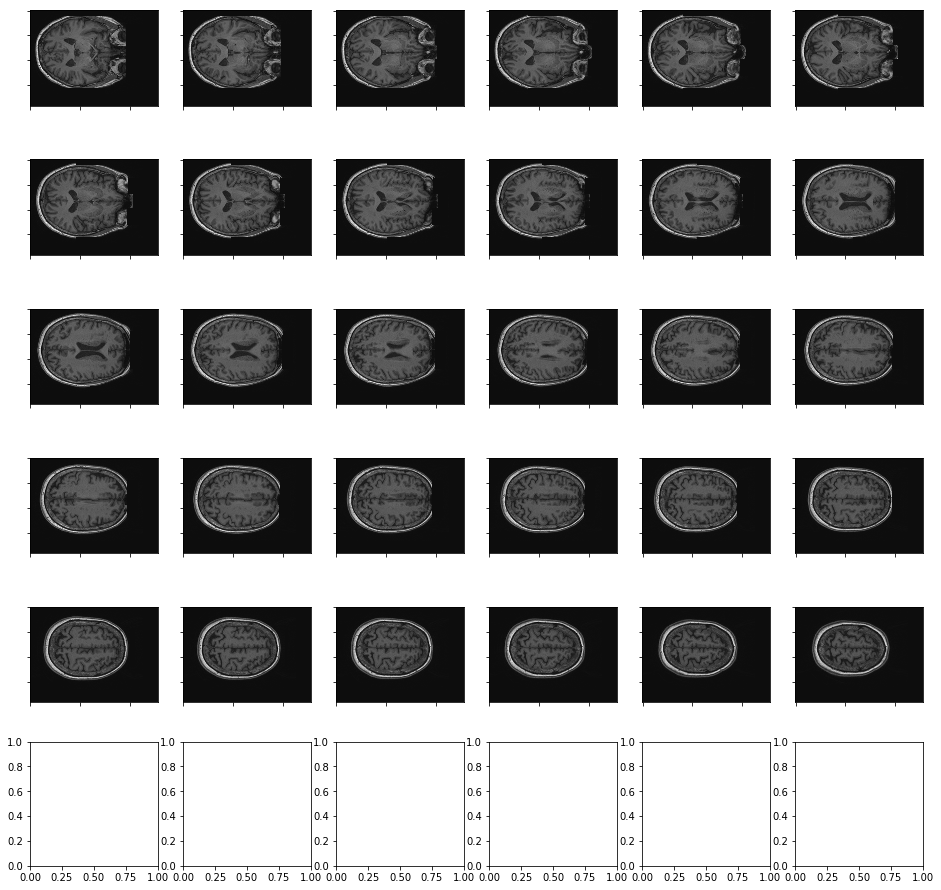

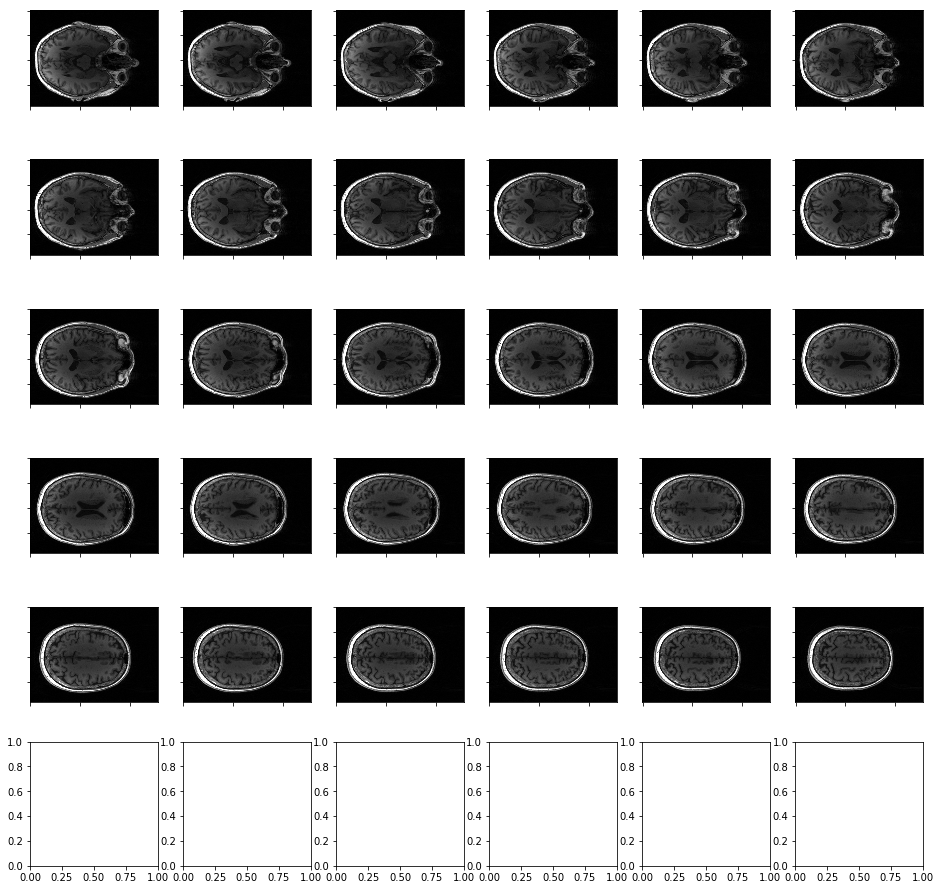

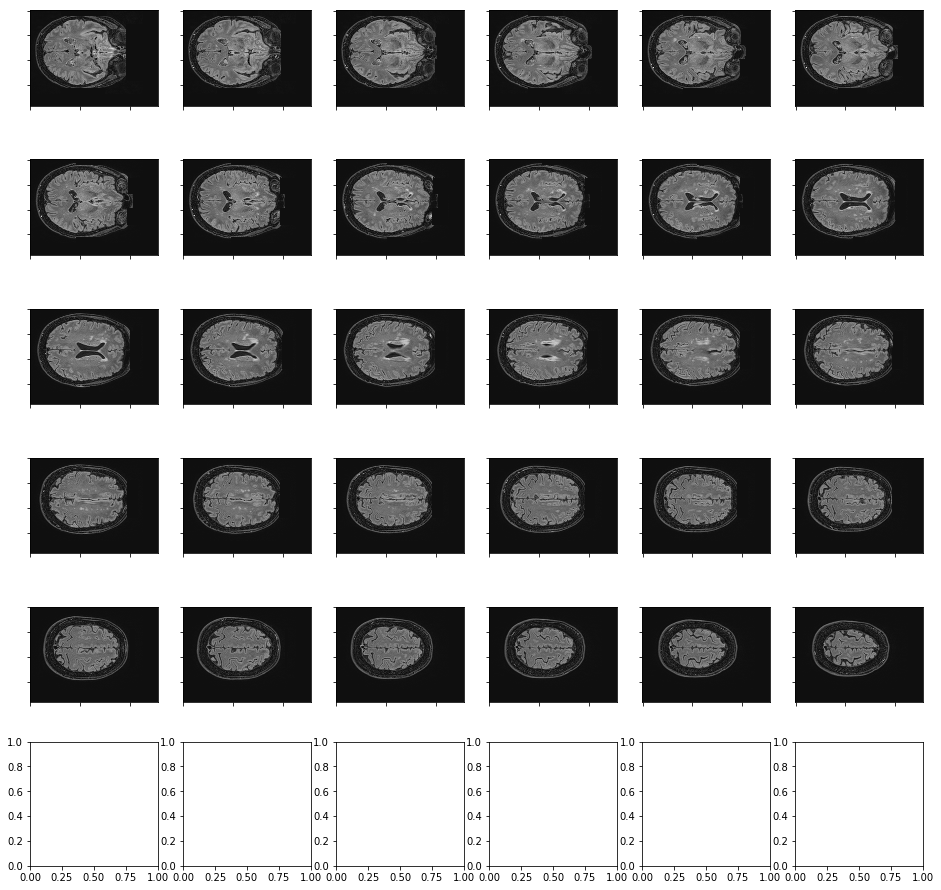

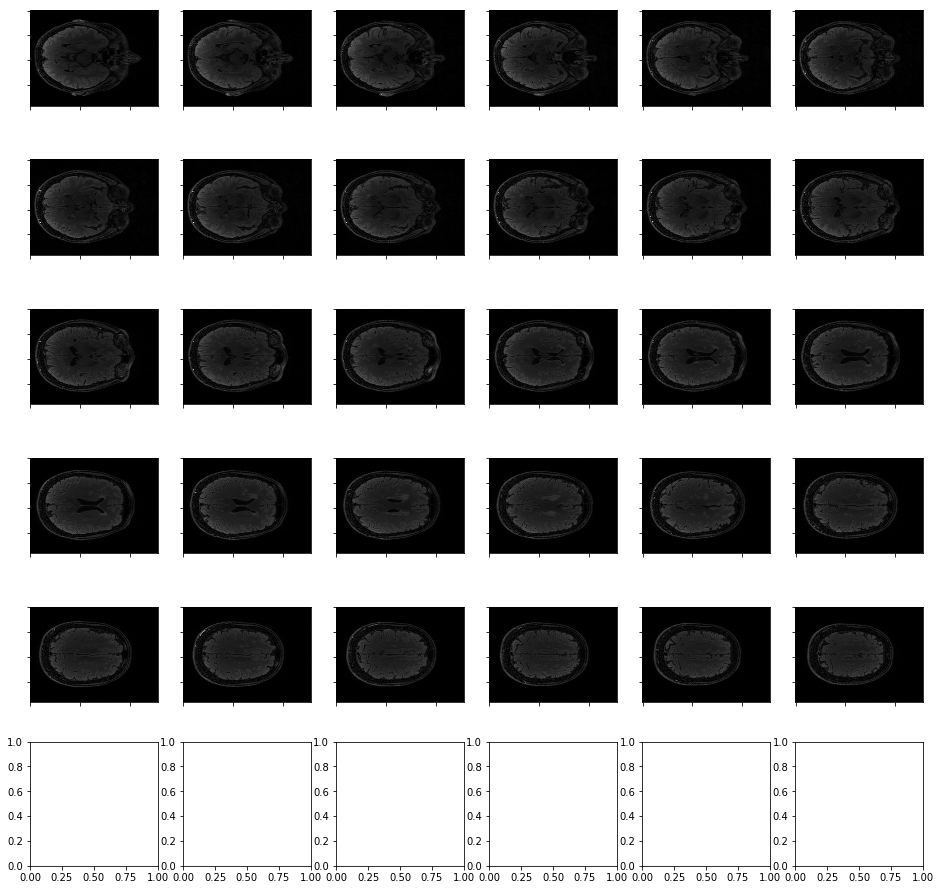

In [5]:
for k in t:
    plot_nifti_array_3d(t[k])

(192, 256, 30)
(192, 256, 30)
(192, 256, 30)
(192, 256, 30)


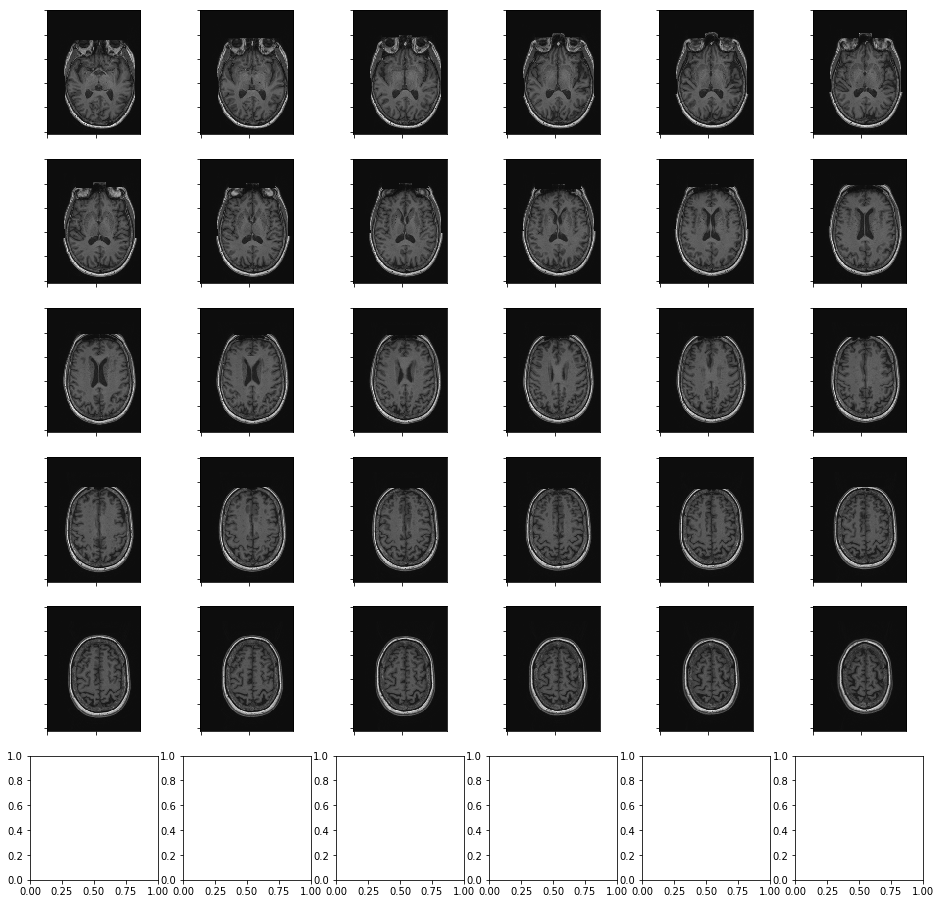

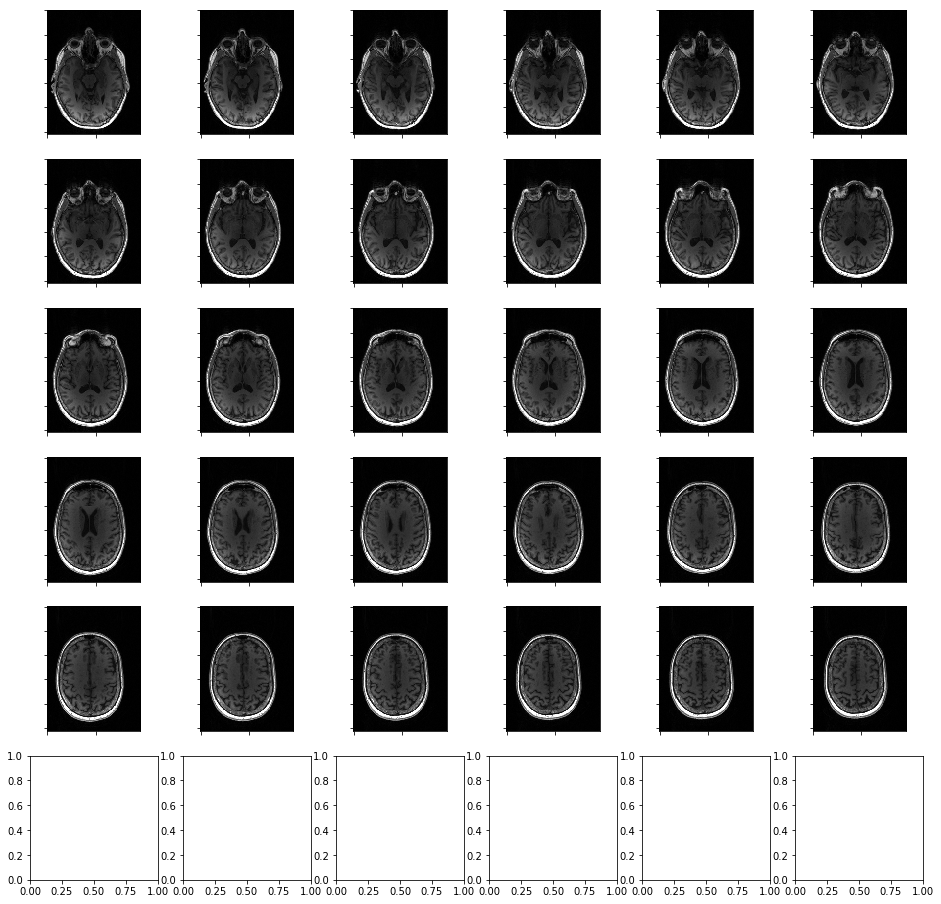

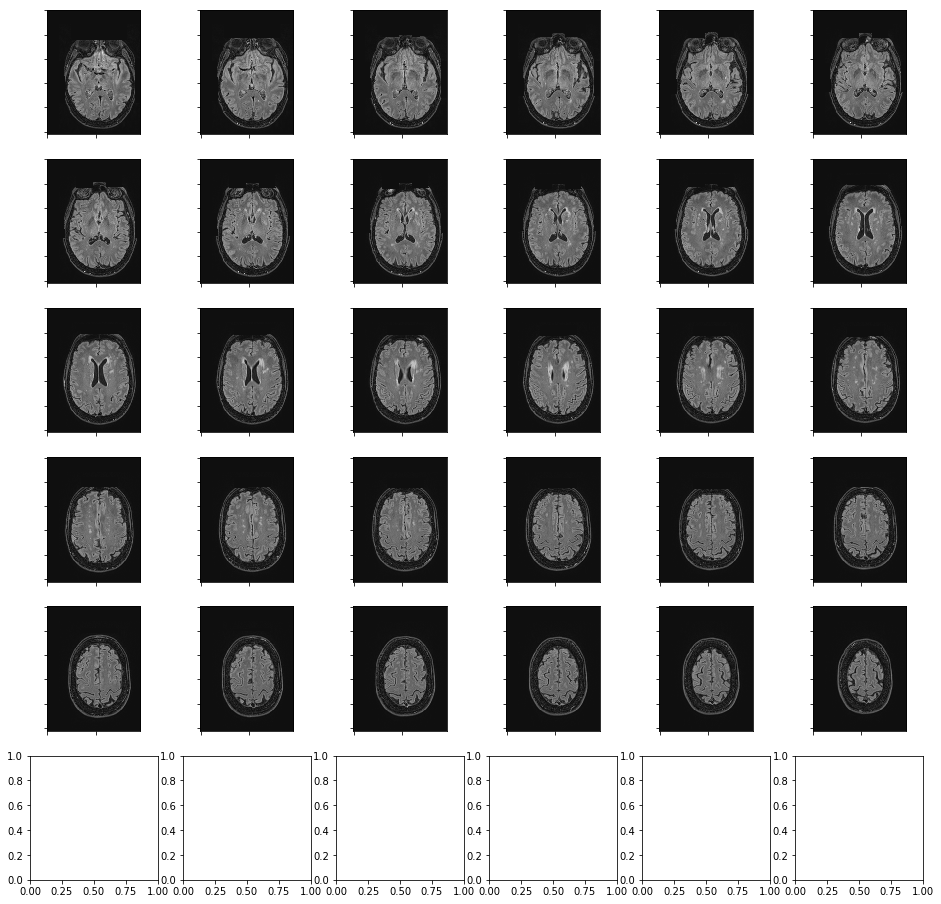

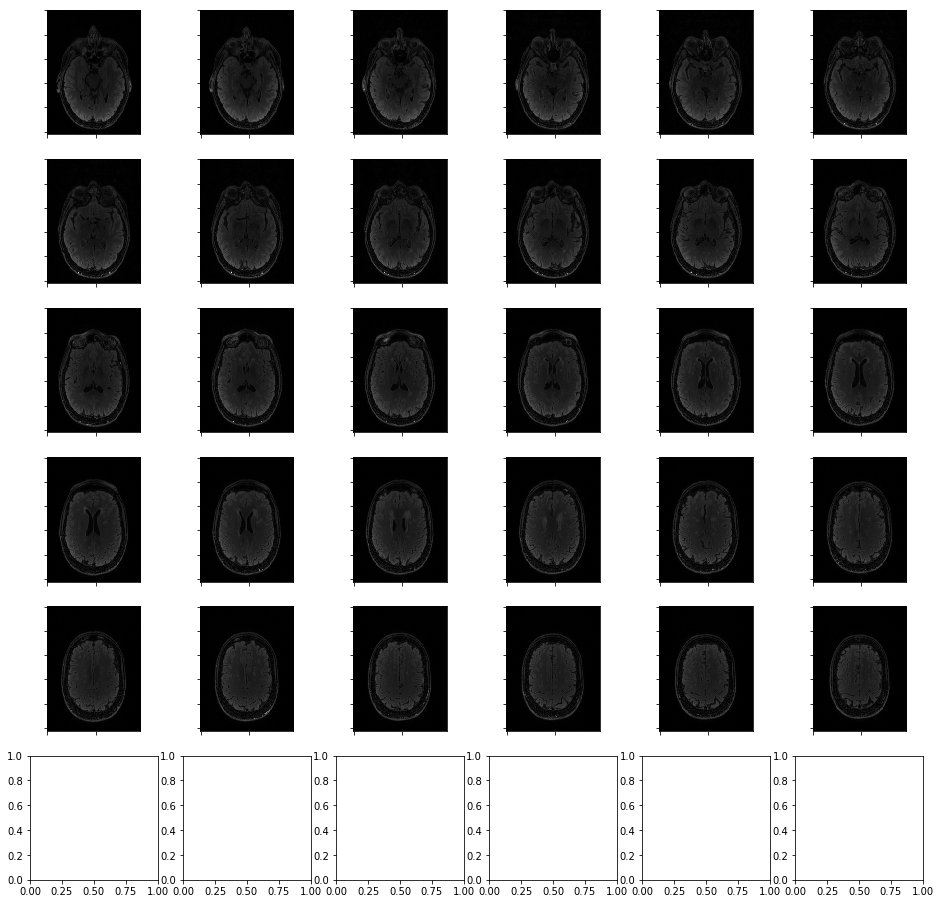

In [11]:
for k in t:
    plot_nifti_array_3d(t[k])

In [ ]:
for f in os.listdir('/mnt/disks/brain-tensors-all-40k/2020-01-14/'):
    t = tmaps_by_sample_id('/mnt/disks/brain-tensors-all-40k/2020-01-14/', f.replace('.hd5', ''), tmaps)
    if not (len(t) == 4 or len(t) == 2):
        continue
    for k in t:
        print(f, k.name, 'has', t[k].shape)